# Lab: RNNs for Sentiment Analysis (with Attention)


------------------------------------------------------

*Andrés Delicado Escudero*


*Pablo Ares Arenas*

------------------------------------------------------


## First of all, we are going to import all the data and do the preprocesing.


In [ ]:
# To use it in colab, update spacy
!pip install --upgrade spacy


In [ ]:
# Download language model

!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 10.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import numpy as np
import pandas as pd
import spacy


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [ ]:

import os
from google.colab import drive
import torch
drive.mount('/content/drive')

ruta_directorio = '/content/drive/MyDrive/Project Neural Networks'

os.chdir(ruta_directorio)

Mounted at /content/drive


In [ ]:
with open("Sentences.txt", "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

In lines, we have a list of sentences and an associted label, separated by the character `@`

In [ ]:
print(lines[0])

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral



We split the sentence and we code with 0 neutral labels, with 1 negative labels, and with 2 positive labels

In [ ]:
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]


def code_opinion(l):

    d = 0

    if (l=='negative\n'):

        d = 1

    elif (l=='positive\n'):

        d = 2

    return d

labels = np.array([code_opinion(l) for l in opinions])


In [ ]:
df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})

Lets plot the histogram of the labels ...

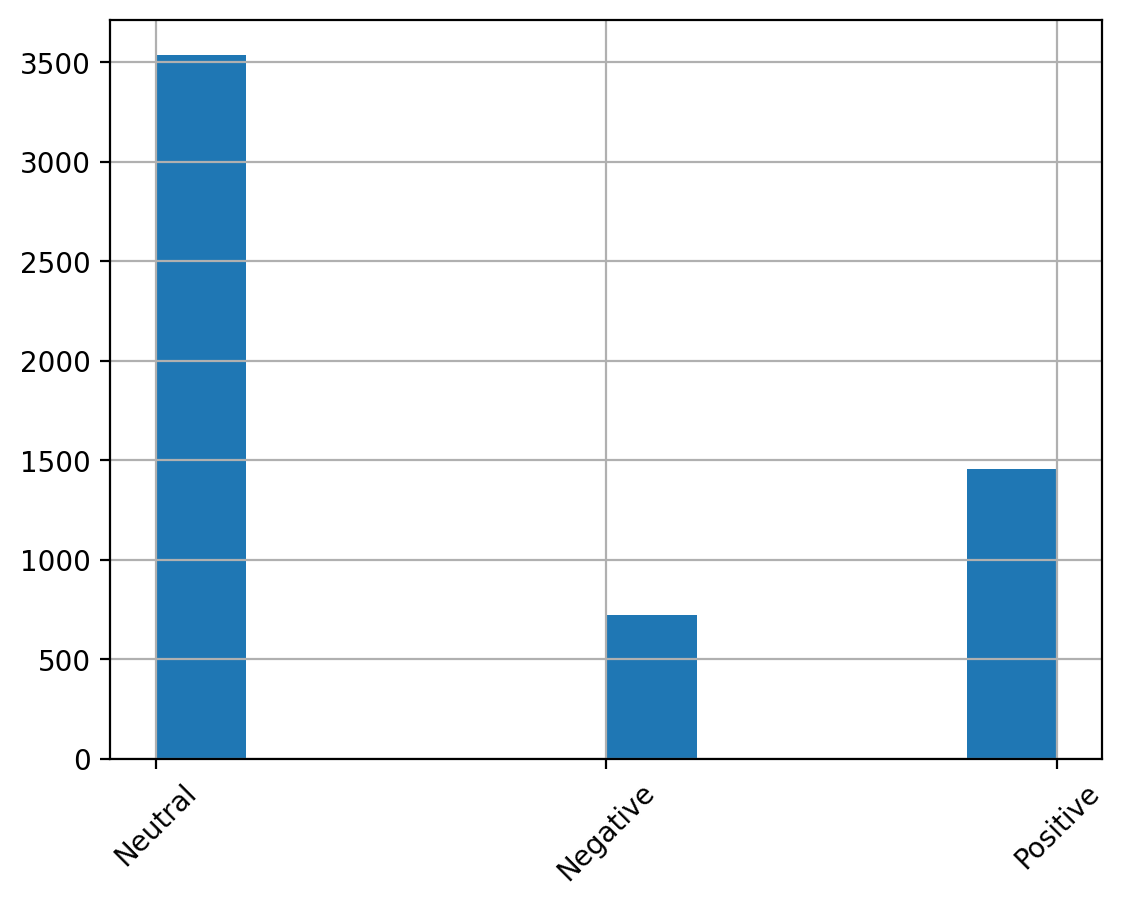

In [ ]:
fig,ax = plt.subplots(1,1)

ax.hist(labels)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Neutral','Negative','Positive'],rotation=45)
ax.grid()


To simplify the problem, we're fusing together *Neutral* and *Positive* labels. So label 1 is *Negative review* and label 0 is *Positive+Neutral*. Also, we separate between train, validation and test.

In [ ]:
from sklearn.model_selection import train_test_split

labels_bin = labels.copy()

labels_bin[labels_bin==2] = 0

idx_data = np.arange(0,len(df),1)

# Separamos train de test
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)

# Separamos train de val
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)

acc_baseline_train = np.sum(y_train==0)/y_train.shape[0]

### Text pre-processing

With the following code, we pre-process using Spacy each sentence by removing words that are punctuation marks. We also remove [stopping words](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html) (words that are not very informative). As a result, we have the list `norm_docs`.

In [ ]:
nlp = spacy.load("en_core_web_md") # Language model


docs = [nlp(c) for c in phrases]

# We remove punctuation marks (.,;:?!...) and stopping words
def normalize(doc):

    return [w for w in doc if w.has_vector and not w.is_punct and not w.is_stop]

norm_docs = [normalize(d) for d in docs]



Every item of `norm_docs` corresponds to each of the sentences in the dataset. Each item is itself a list of spacy tokens (basically words with different attributes). The most important attribute for us the the *word embedding vector*. For instance, lets print the first sentence

In [ ]:
print(f'The first original sentence is: {phrases[0]}\n')

print(f'The first normalized sentence is: {norm_docs[0]}. The length of the document is {len(norm_docs[0])} tokens')

The first original sentence is: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .

The first normalized sentence is: [According, Gran, company, plans, production, Russia, company, growing]. The length of the document is 8 tokens


We can access to the word embedding of each token using the attribute `.vector`:

In [ ]:
print(f'The word embedding associated with the token {norm_docs[0][0].text} is\n')
print(norm_docs[0][0].vector)

The word embedding associated with the token According is

[-7.2518e-01 -6.5831e+00  1.9781e+00  1.5750e+00  3.7848e+00 -7.7536e-01
  1.6243e+00  1.3813e+00 -7.4554e-01 -3.3811e+00  5.6047e-01  1.1629e+00
 -9.7465e-01  6.6956e-01  4.2558e-01  4.1766e+00  4.6478e+00  3.5616e+00
  7.3597e-01  3.6554e-01 -2.2610e+00 -4.1928e+00 -6.7455e-01  1.7693e+00
 -1.5665e-01 -1.1390e+00  1.8747e+00  2.9538e+00  5.5879e-01  3.0424e-01
  2.3027e-01  3.6405e-02  8.8395e-01  1.0494e+00 -1.7269e+00 -3.3406e-01
 -1.0464e+00 -9.8123e-01 -2.1267e+00 -2.9542e+00 -4.3075e+00 -1.5900e+00
 -8.9226e-01  3.6363e-01 -3.7703e+00 -1.8992e+00 -5.3433e-01  4.0256e+00
 -1.8628e+00 -1.9761e+00  1.2977e+00  3.6029e+00  1.6310e+00 -2.5195e+00
  2.0482e+00 -1.4805e+00 -1.4294e-01 -2.7591e+00 -3.4827e-01 -6.1484e+00
 -5.9045e-01 -5.3691e-01 -7.3631e-01  3.1585e+00  5.7914e+00 -1.1208e+00
 -2.5045e+00 -2.2957e+00  2.7173e+00  1.1104e+00  2.0943e+00 -2.6719e+00
 -2.6322e+00 -3.9377e+00 -1.3198e+00  3.5639e+00 -1.3974e+00  2.7

You can check that the word embedding dimension is 300 ...

In [ ]:
print(f'The WE dimension is {norm_docs[0][0].vector.shape}')

The WE dimension is (300,)


### Length normalization

Note that in this problem we're working with sequences of text of different length. This is in principle not a problem for RNNs. However, there's one additional pre-processing step that we have to do. When we feed the RNN function **all sequences in the mini-batch must have the same length**. Then we will use the corresponding state to make the prediction.

For simplicity, we are taking here a non-efficient solution. Instead of normalize lengths at a batch level, we are normalizing the whole dataset so all sequences have the same length. To do so, we're adding **junk tokens** to all sentences so they artificially are of the same length. However, we will keep in a list the real length of each data, since the sentiment analysis prediction will be made using the RNN state corresponding to the **last real token**.



In [ ]:
# List with the length for each sentence

lengths = [len(d) for d in norm_docs]

# Maximum length (in train!)
max_l = np.max([lengths[d] for d in idx_train])

In [ ]:
# We add as many junk tokens (#) as needed to equalize the length of each sentence to max_l

garbage_token = nlp('#') # Junk token --> #

# We normalize the dataset

norm_docs_eq_length = [norm_docs[d]+[garbage_token]*(max_l-lengths[d]) for d in range(len(norm_docs))]

# Train documents

docs_train = [norm_docs_eq_length[d] for d in idx_train]

len_train = [lengths[d] for d in idx_train]

# Validation documents

docs_val = [norm_docs_eq_length[d] for d in idx_val]

len_val = [lengths[d] for d in idx_val]

# documentos test

docs_test = [norm_docs_eq_length[d] for d in idx_test]

len_test = [lengths[d] for d in idx_test]

Recall that for each document, the sequence of word embeddings is obtained using the `.vector` attribute per token ...

In [ ]:
# Until Here is the same code as last notebook and here we start implementing the attention class


## RNN classification with Attention

#### Creating the models



Following the dynamic of the previous script, first we are going to create the parent class and later a new class that inherits from this one, and adds the train, fit and save functionalities

In [ ]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
# Directorio para guardar los modelos entrenados
saved_models_dir = './saved_models'

# Verificar si el directorio ya existe
if not os.path.exists(saved_models_dir):
    # Si no existe, crear el directorio
    os.makedirs(saved_models_dir)
else:
    print("El directorio ya está creado.")

El directorio ya está creado.


In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        # Primera capa lineal
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        # Segunda capa lineal para producir un peso escalar
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, query, values):
        # query: (batch_size, hidden_dim)
        # values: (batch_size, seq_length, hidden_dim)
        query = query.unsqueeze(1)  # Transforma la consulta para operaciones de broadcasting
        weights = self.fc1(values)  # Aplica la primera capa lineal
        weights = torch.tanh(weights)  # Aplica la activación tanh
        weights = self.fc2(weights)  # Calcula los pesos sin normalizar
        weights = weights.squeeze(2)  # Elimina la dimensión redundante
        weights = F.softmax(weights, dim=1)  # Aplica softmax para normalizar los pesos
        context = torch.sum(weights.unsqueeze(2) * values, dim=1)  # Calcula el vector de contexto
        return context, weights


In [ ]:
class RNN_with_Attention(nn.Module):                                #we implement from the beggining the bidirectional option
    def __init__(self, input_size, output_size, hidden_dim, n_layers, prob=0.5, bidirectional=False):
        super(RNN_with_Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_size = input_size

        # Definir la RNN (LSTM en este caso)
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True,  bidirectional=self.bidirectional)

        # Capa de atención utilizando la clase Attention definida anteriormente
        #Watch out because a bidirectional approach would also affect to the hidden dimensions of the attention
        self.attention = Attention(hidden_dim * self.num_directions)

        # Capa fully-connected final
        self.fc1 = nn.Linear(hidden_dim * self.num_directions, output_size)

        # LogSoftmax para la salida
        self.logsoftmax = nn.LogSoftmax(dim=1)

        # Capa de Dropout
        self.dropout = nn.Dropout(p=prob)

    def forward(self, x, lengths, h0=None):
        batch_size = x.size(0)

        # Obtener las salidas de la RNN
        r_out, _ = self.rnn(x)

        # Usar el último estado válido como consulta para la atención
        queries = torch.stack([r_out[i, length-1] for i, length in enumerate(lengths)])

        # Aplicar atención usando los estados hasta el último válido (excluyendo tokens de relleno)
        context, attn_weights = self.attention(queries, r_out[:, :max(lengths)])

        # Aplicar dropout, pasar por la capa lineal y luego aplicar log softmax
        output = self.logsoftmax(self.fc1(self.dropout(context)))

        return output, attn_weights




In [ ]:
class RNN_with_train(RNN_with_Attention):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, prob=0.0, batch_size=50, lr=0.0005, saved_files='./saved_models/RNN_sentiment_analysis', bidirectional=False):
        super().__init__(input_size, output_size, hidden_dim, n_layers, prob, bidirectional)
        self.lr = lr  # Tasa de aprendizaje
        self.optim = optim.Adam(self.parameters(), lr)
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []
        self.valid_loss_during_training = []
        self.batch_size = batch_size
        self.saved_files = saved_files

    def predict_proba(self, docs, lengths, Y=None):
        '''Obtener la salida de la red para un conjunto de documentos.'''
        accuracy = 0.0
        with torch.no_grad():
            x_input = torch.Tensor([[w.vector for w in d] for d in docs])
            logprobs, _ = self.forward(x_input, lengths)
            if Y is not None and len(Y) > 0:
                accuracy = np.sum(np.argmax(logprobs.detach().numpy(), axis=1) == Y) / len(Y)
        return logprobs, accuracy


    def fit(self, docs_train, docs_val, Y_train, Y_val, len_train, len_val, epochs=100, print_every=5):
        '''Método de entrenamiento para el modelo con atención.'''
        for e in range(epochs):
            self.train()
            running_loss = 0.0
            indices = np.random.permutation(len(docs_train))

            for i in range(0, len(docs_train), self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                x_input = torch.Tensor([[w.vector for w in docs_train[idx]] for idx in batch_indices if len_train[idx] > 0])
                y_batch = torch.Tensor([Y_train[idx] for idx in batch_indices if len_train[idx] > 0]).long()

                self.optim.zero_grad()
                output, _ = self.forward(x_input, [len_train[idx] for idx in batch_indices if len_train[idx] > 0])
                loss = self.criterion(output, y_batch)
                loss.backward()
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                self.optim.step()
                running_loss += loss.item()

            if e % print_every == 0:
                avg_train_loss = running_loss / (len(docs_train) // self.batch_size)
                print(f"Epoch {e+1}/{epochs}, Training Loss: {avg_train_loss}")

                # Almacenar la pérdida de entrenamiento en la lista
                self.loss_during_training.append(avg_train_loss)

                # Evaluar el modelo en el conjunto de validación
                self.eval()
                val_loss, val_accuracy = self.evaluate(docs_val, Y_val, len_val)
                print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

                # Almacenar la pérdida de validación en la lista
                self.valid_loss_during_training.append(val_loss)


    def evaluate(self, docs_val, Y_val, len_val):
        '''Evaluación del modelo en el conjunto de validación.'''
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for idx in range(0, len(docs_val), self.batch_size):
                # Preparar los batches
                batch_docs = docs_val[idx:idx + self.batch_size]
                batch_labels = Y_val[idx:idx + self.batch_size]
                batch_lengths = len_val[idx:idx + self.batch_size]

                # Convertir documentos a tensores de vectores
                x_input = torch.Tensor(np.array([[w.vector for w in doc] for doc in batch_docs]))
                labels = torch.Tensor(batch_labels).long()

                # Calcular la salida del modelo
                outputs, _ = self.forward(x_input, batch_lengths)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()

                # Calcular la precisión
                predictions = outputs.argmax(dim=1)
                correct_predictions += (predictions == labels).sum().item()
                total_samples += len(batch_docs)

        # Calcular promedios
        average_loss = total_loss / (len(docs_val) // self.batch_size) if total_samples > 0 else 0
        accuracy = correct_predictions / total_samples if total_samples > 0 else 0
        return average_loss, accuracy


In [ ]:
my_RNN_atenta = RNN_with_train(input_size=300, output_size=2, hidden_dim=20, n_layers=1, prob=0.3)
my_RNN_atenta.fit(docs_train, docs_val, y_train, y_val, len_train, len_val, epochs=30, print_every=1)

<ipython-input-21-52360a1bcfe3>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  x_input = torch.Tensor([[w.vector for w in docs_train[idx]] for idx in batch_indices if len_train[idx] > 0])


Epoch 1/30, Training Loss: 0.43916179627588353
Validation Loss: 0.37193163401550716, Validation Accuracy: 0.8841530054644808
Epoch 2/30, Training Loss: 0.35593905942897275
Validation Loss: 0.3253420549962256, Validation Accuracy: 0.8841530054644808
Epoch 3/30, Training Loss: 0.32130454623535887
Validation Loss: 0.29537224686808056, Validation Accuracy: 0.892896174863388


KeyboardInterrupt: 

In [ ]:
print(my_RNN_atenta.valid_loss_during_training)
print(my_RNN_atenta.loss_during_training)

In [ ]:

import matplotlib.pyplot as plt

# Plotting the train/val loss
plt.plot(range(1, len(my_RNN_atenta.loss_during_training) + 1), my_RNN_atenta.loss_during_training, label='Training Loss')
plt.plot(range(1, len(my_RNN_atenta.valid_loss_during_training) + 1), my_RNN_atenta.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Calcular las log-probabilidades y la precisión para el conjunto de datos de prueba
logprobs, acc = my_RNN_atenta.predict_proba(docs_test, len_test, y_test)

# Exponenciar las log-probabilidades para obtener las probabilidades
probs = np.exp(logprobs)

# Imprimir la precisión del test
print(f"The test accuracy is {acc}")


In [ ]:
from sklearn import metrics

# Calcular la curva ROC
fpr, recall, thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1)

# Trazar la curva ROC
fig, ax = plt.subplots()
plt.plot(fpr, recall, lw=2.5, label='ROC curve LSTM')
plt.legend(loc=7)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

# Calcular el área bajo la curva ROC
area_roc_LSTM = metrics.roc_auc_score(y_test, probs[:,1])

print(f"AUC ROC for LSTM is {area_roc_LSTM}")


## Now lets see if it improves using a bidirectional LSTM

Although in the previous script using a biderictional LSTM made the accuracy decrease (we explain our intuitions about it on the conclusions at the end), we think that now it could be usefull, because attention allows the model to focus on specific parts of the input sequence, which can make bidirectionality more effective by allowing the model to capture relevant features both forwards and backwards in the sequence.

In [ ]:
RNN_with_train_and_bidirectional = RNN_with_train(input_size=300, output_size=2, hidden_dim=20, n_layers=1, prob=0.3, bidirectional=True)
RNN_with_train_and_bidirectional.fit(docs_train, docs_val, y_train, y_val, len_train, len_val, epochs=30, print_every=1)

In [ ]:
import matplotlib.pyplot as plt

# Plotting the train/val loss
plt.plot(range(1, len(RNN_with_train_and_bidirectional.loss_during_training) + 1), RNN_with_train_and_bidirectional.loss_during_training, label='Training Loss')
plt.plot(range(1, len(RNN_with_train_and_bidirectional.valid_loss_during_training) + 1), RNN_with_train_and_bidirectional.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Calcular las log-probabilidades y la precisión para el conjunto de datos de prueba
logprobs, acc = RNN_with_train_and_bidirectional.predict_proba(docs_test, len_test, y_test)

# Exponenciar las log-probabilidades para obtener las probabilidades
probs = np.exp(logprobs)

# Imprimir la precisión del test
print(f"The test accuracy using bidirectional LSTM is {acc}")


In [ ]:
from sklearn import metrics

# Calcular la curva ROC
fpr, recall, thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1)

# Trazar la curva ROC
fig, ax = plt.subplots()
plt.plot(fpr, recall, lw=2.5, label='ROC curve LSTM')
plt.legend(loc=7)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

# Calcular el área bajo la curva ROC
area_roc_LSTM = metrics.roc_auc_score(y_test, probs[:,1])

print(f"AUC ROC for LSTM is {area_roc_LSTM}")
